# Power Plants Regression

In [25]:
import pandas as pd

# Load dataset
# (file copied into this repo as `usina_with_outliers.csv`)
df = pd.read_csv('usina_with_outliers.csv')

df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### Model Choice: Linear Regression (OLS)
- I chose OLS for this dataset since Lasso Regression try to suppress outliers. However, for this Python Notebook's analysis to be relevant to Cook's distance (which calculates the difference removing a data point makes on a model), the outliers need to be considered in our analysis, rather than smoothed. OLS is intentionally sensitive to influential observations, which allows Cook's distance to effectively identify points that disproportionally affect the fitted model.

### Library Choice: Statsmodels OLS
- I chose Statsmodels since it is made for diagnostics, however, scikit-learn is built for predicitons. Statsmodels gives us access to all of the metrics Cook's distance depends on.



In [26]:
from sklearn.model_selection import train_test_split

# 70/30 random split (reproducible)
train_df, test_df = train_test_split(df, test_size=0.30, random_state=42)

# Quick sanity-check on sizes
print(f"Total rows: {len(df)}")
print(f"Train rows: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test rows:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Reset indices for clean train/test frames
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Total rows: 9568
Train rows: 6697 (70.0%)
Test rows:  2871 (30.0%)


In [27]:
import statsmodels.api as sm

# Fit OLS on training data: predict PE from AT, V, AP, RH
X = train_df[['AT', 'V', 'AP', 'RH']]
y = train_df['PE']

X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()

# Cook's distance for each training point
influence = ols_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Threshold rule: 4/n
n = len(train_df)
threshold = 4 / n

train_df_with_cooks = train_df.copy()
train_df_with_cooks['cooks_distance'] = cooks_d
train_df_with_cooks['is_outlier'] = train_df_with_cooks['cooks_distance'] > threshold

print(f"n (train) = {n}")
print(f"Cook's distance threshold (4/n) = {threshold:.6f}")
print(f"Outliers detected = {train_df_with_cooks['is_outlier'].sum()}")

# Remove outliers
train_df_no_outliers = train_df_with_cooks.loc[~train_df_with_cooks['is_outlier']].drop(columns=['is_outlier'])

# Save cleaned training data
train_df_no_outliers.to_csv('usina.csv', index=False)
print("Saved cleaned dataset to usina.csv")

n (train) = 6697
Cook's distance threshold (4/n) = 0.000597
Outliers detected = 85
Saved cleaned dataset to usina.csv


## Model Training & Evaluation — OLS, Ridge, Lasso

Below we train OLS (LinearRegression), Ridge, and Lasso on both `usina_with_outliers.csv` and the cleaned `usina.csv`, and report train/test MSE, MAE, and R².

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

ALPHAS = [0.01, 0.1, 1, 10, 100]


def evaluate_and_display(path):
    # Load and drop any NA rows
    df = pd.read_csv(path).dropna()

    # Features / target
    X = df[['AT', 'V', 'AP', 'RH']]
    y = df['PE']

    # 70/30 split (same random_state used earlier)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    rows = []

    def record(model_name, model):
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        rows.append({
            'Model': model_name,
            'MSE (Train)': mean_squared_error(y_train, y_pred_train),
            'MAE (Train)': mean_absolute_error(y_train, y_pred_train),
            'R2 (Train)': r2_score(y_train, y_pred_train),
            'MSE (Test)': mean_squared_error(y_test, y_pred_test),
            'MAE (Test)': mean_absolute_error(y_test, y_pred_test),
            'R2 (Test)': r2_score(y_test, y_pred_test),
        })

    # OLS (LinearRegression)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    record('LinearRegression', lr)

    # Ridge for requested alphas
    for a in ALPHAS:
        r = Ridge(alpha=a)
        r.fit(X_train, y_train)
        record(f'Ridge (alpha={a})', r)

    # Lasso for requested alphas
    for a in ALPHAS:
        l = Lasso(alpha=a, max_iter=10000)
        l.fit(X_train, y_train)
        record(f'Lasso (alpha={a})', l)

    results_df = pd.DataFrame(rows)
    # Round for display
    results_df = results_df.round({
        'MSE (Train)': 4, 'MAE (Train)': 4, 'R2 (Train)': 4,
        'MSE (Test)': 4, 'MAE (Test)': 4, 'R2 (Test)': 4
    })

    print('\n' + '='*80)
    print(f"Dataset: {path} — rows={len(df)} — train/test: {len(X_train)}/{len(X_test)}")
    display(results_df)
    return results_df

# Run for both files
results_with_outliers = evaluate_and_display('usina_with_outliers.csv')
results_cleaned = evaluate_and_display('usina.csv')

# Optionally, save results to CSV inside notebook
results_with_outliers.to_csv('usina_with_outliers_metrics.csv', index=False)
results_cleaned.to_csv('usina_metrics.csv', index=False)
print('\nSaved metrics to usina_with_outliers_metrics.csv and usina_metrics.csv')


Dataset: usina_with_outliers.csv — rows=9568 — train/test: 6697/2871


,Model,MSE (Train),MAE (Train),R2 (Train),MSE (Test),MAE (Test),R2 (Test)
0,LinearRegression,123.3842,5.1987,0.6502,125.1134,5.0525,0.6426
1,Ridge (alpha=0.01),123.3842,5.1987,0.6502,125.1134,5.0525,0.6426
2,Ridge (alpha=0.1),123.3842,5.1987,0.6502,125.1134,5.0525,0.6426
3,Ridge (alpha=1),123.3842,5.1987,0.6502,125.1134,5.0525,0.6426
4,Ridge (alpha=10),123.3842,5.1987,0.6502,125.1137,5.0525,0.6426
5,Ridge (alpha=100),123.3842,5.1993,0.6502,125.1165,5.0530,0.6426
6,Lasso (alpha=0.01),123.3842,5.1989,0.6502,125.1153,5.0526,0.6426
7,Lasso (alpha=0.1),123.3846,5.2017,0.6502,125.1345,5.0553,0.6425
8,Lasso (alpha=1),123.4212,5.2295,0.6501,125.3384,5.0831,0.6419
9,Lasso (alpha=10),126.1415,5.5404,0.6424,128.9021,5.4088,0.6318



Dataset: usina.csv — rows=6612 — train/test: 4628/1984


,Model,MSE (Train),MAE (Train),R2 (Train),MSE (Test),MAE (Test),R2 (Test)
0,LinearRegression,19.4535,3.5712,0.9334,20.1667,3.6183,0.9283
1,Ridge (alpha=0.01),19.4535,3.5712,0.9334,20.1667,3.6183,0.9283
2,Ridge (alpha=0.1),19.4535,3.5712,0.9334,20.1667,3.6183,0.9283
3,Ridge (alpha=1),19.4535,3.5712,0.9334,20.1668,3.6183,0.9283
4,Ridge (alpha=10),19.4535,3.5712,0.9334,20.1673,3.6184,0.9283
5,Ridge (alpha=100),19.4537,3.5716,0.9334,20.1727,3.6193,0.9283
6,Lasso (alpha=0.01),19.4535,3.5711,0.9334,20.1669,3.6183,0.9283
7,Lasso (alpha=0.1),19.4541,3.5715,0.9334,20.1768,3.6198,0.9283
8,Lasso (alpha=1),19.5181,3.5800,0.9331,20.3322,3.6402,0.9277
9,Lasso (alpha=10),25.0543,4.0404,0.9142,26.5588,4.1813,0.9056



Saved metrics to usina_with_outliers_metrics.csv and usina_metrics.csv


### Do outliers change train error? Test error?
- Train: As can be seen from the table where we evaluate metrics, the train MAE and MSE values range from 5-11 (MAE) and 123-234 (MSE), which is a higher range as compared to the same values for the dataset without outliers, where it ranges from 3-9 (MAE) and 19-131 (MSE). Similarly, the train R2 values for usina_with_outliers.csv (around 0.6) are significantly smaller than those for usina.csv (around 0.9) which are much closer to 1.
- Test: The same pattern can be noticed for test MAE and MSE, wherein the test MAE (5-11) and MSE (125-233) values are much higher for the dataset with outliers as compared to the test MAE (3-9) and MSE (20-127) values for the dataset without outliers.
These observations prove that the outliers change both train and test errors, increasing errors when they are present in the dataset.

### Which dataset (with outliers vs without outliers) shows better generalization?
- The dataset without outliers shows better generalization. It has lower MAE and MSE values, along with higher R2 values, making its absolute error lesser as compared to the dataset with outliers. Further, the train and test metric values are pretty similar (MSE ~ 20, MAE ~3.6, R2 ~0.9), which shows that this model is neither underfitted nor overfitted. While the values are similar for the dataset with outliers as well, this dataset has a larger absolute error, which is why we conclude that the dataset without outliers generalizes better.

### Do Ridge/Lasso appear to help relative to standard linear regression?
- No. For both of our datasets, Ridge/Lasso do absolutely nothing to improve error metrics. In fact, their performance only gets worse as the Lasso alpha increases. These only help when models are overfitting, however, as proven in the last response, our OLS model is not overfitting. Thus, these do not appear to help relative to standard linear regression.

# Most/Least Reliable Coefficients

### Model Choice: Linear Regression
- I chose this model since to calculate the most/least reliable coefficients, we need access to statistically interpretable coefficient estimates along with standard errors, t-values, and p-values, which allow direct evaluation of coefficient stability. Ridge/Lasso modify coefficient magnitudes, but for the purpose of least/most reliable, we need access to the real values, which is what OLS gives us.

### Library Choice: Statsmodels OLS
- I chose Statsmodels since it is made for diagnostics, however, scikit-learn is built for predicitons. Statsmodels gives us access to all of the metrics Cook's distance depends on.

### Scale IVs and/or DVs: No
- We do not scale IVs or DVs for this coefficient reliability task. This is because reliability is based off of metrics like t-value, p-value, standard errors, and confidence levels, all of which are defined relative to the units of the predictor. Scaling would change coefficient magnitudes and standard errors, which would not give us a credible answer for this coefficient reliability task.

## Most and Least Reliable Coefficients (OLS)

This cell computes coefficient estimates and diagnostic tables for both unscaled and scaled variants. The output shows standardized coefficients and OLS t-statistics so you can identify the most and least reliable predictors.

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from IPython.display import display

# Load cleaned dataset (outliers removed)
df = pd.read_csv('usina.csv')

# Feature names and matrices
feature_names = ['AT','V','AP','RH']
X = df[feature_names]
y = df['PE']

# Train/test split (70/30) consistent with earlier cells
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X, y, test_size=0.30, random_state=42)

# Scaled versions
x_scaler = StandardScaler()
X_train_sc = x_scaler.fit_transform(X_train_un)
X_test_sc = x_scaler.transform(X_test_un)

y_scaler = StandardScaler()
y_train_sc = y_scaler.fit_transform(y_train_un.values.reshape(-1,1))
y_test_sc = y_scaler.transform(y_test_un.values.reshape(-1,1))


def eval_metrics(y_true, y_pred):
    # expects numpy arrays or pandas series (y_pred same shape as y_true)
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    return {
        'MSE': float(mean_squared_error(y_true, y_pred)),
        'MAE': float(mean_absolute_error(y_true, y_pred)),
        'R2':  float(r2_score(y_true, y_pred))
    }


def standardized_coef_unscaled(beta, X_train, y_train):
    # beta: array of shape (n_features,)
    # standardized coef = beta_j * std(X_j) / std(y)
    x_std = X_train.std(axis=0).values
    y_std = y_train.std()
    return (beta * x_std) / y_std


def convert_scaled_coef_to_original(beta_scaled, intercept_scaled, x_scaler, y_scaler):
    # beta_scaled: array in scaled space, intercept_scaled: scalar in scaled y-space
    x_scale = x_scaler.scale_
    x_mean = x_scaler.mean_
    y_scale = float(y_scaler.scale_)
    y_mean = float(y_scaler.mean_)

    beta_orig = (y_scale * beta_scaled) / x_scale
    intercept_orig = y_mean + y_scale * intercept_scaled - np.sum(beta_orig * x_mean)
    return beta_orig, intercept_orig


def linear_with_ols_reports():
    reports = {}
    # unscaled: use pandas inputs for statsmodels
    for variant in ['unscaled','scaled']:
        if variant == 'unscaled':
            Xt_tr, Xt_te = X_train_un, X_test_un
            yt_tr = y_train_un
        else:
            Xt_tr, Xt_te = X_train_sc, X_test_sc
            yt_tr = y_train_sc.ravel()

        # Fit sklearn LinearRegression for coefficient estimates
        lr = LinearRegression()
        lr.fit(Xt_tr, yt_tr)

        pred_tr = lr.predict(Xt_tr).reshape(-1,1)
        pred_te = lr.predict(Xt_te).reshape(-1,1)

        # Evaluate in original y-units
        if variant == 'scaled':
            pred_tr_eval = y_scaler.inverse_transform(pred_tr)
            pred_te_eval = y_scaler.inverse_transform(pred_te)
            y_tr_eval = y_scaler.inverse_transform(yt_tr.reshape(-1,1))
        else:
            pred_tr_eval = pred_tr
            pred_te_eval = pred_te
            y_tr_eval = yt_tr.values.reshape(-1,1)

        mtr = eval_metrics(y_tr_eval, pred_tr_eval)
        # For test metrics always evaluate in original units
        if variant == 'scaled':
            y_test_orig = y_test_sc.copy()
            y_test_orig = y_scaler.inverse_transform(y_test_orig)
            mte = eval_metrics(y_test_orig, pred_te_eval)
        else:
            mte = eval_metrics(y_test_un.values.reshape(-1,1), pred_te)

        # OLS (t-stats)
        # statsmodels expects 2D arrays; if scaled variant, Xt_tr is numpy array
        if variant == 'unscaled':
            X_sm = sm.add_constant(Xt_tr)
            ols = sm.OLS(yt_tr, X_sm).fit()
        else:
            X_sm = sm.add_constant(Xt_tr)
            ols = sm.OLS(yt_tr, X_sm).fit()

        feat_names = ['const'] + feature_names
        ols_table = pd.DataFrame({
                'term': feat_names,
                'beta_hat': np.asarray(ols.params),
                't_value': np.asarray(ols.tvalues),
                'p_value': np.asarray(ols.pvalues)
            }).sort_values('t_value', key=np.abs, ascending=False)

        # Standardized coefficients / coefficient tables
        beta = lr.coef_.reshape(-1)
        if variant == 'unscaled':
            beta_std = standardized_coef_unscaled(beta, X_train_un, y_train_un)
            coef_table = pd.DataFrame({
                'feature': feature_names,
                'coef_value': beta,
                'standardized_coef': beta_std
            }).sort_values('standardized_coef', key=np.abs, ascending=False)
        else:
            # scaled X and scaled y => beta is standardized effect size in scaled space
            beta_orig, intercept_orig = convert_scaled_coef_to_original(beta, float(lr.intercept_), x_scaler, y_scaler)
            coef_table = pd.DataFrame({
                'feature': feature_names,
                'coef_value_(scaled_space)=standardized': beta,
                'coef_value_(original_units)': beta_orig
            }).sort_values('coef_value_(scaled_space)=standardized', key=np.abs, ascending=False)

        reports[variant] = {
            'train_metrics': mtr,
            'test_metrics': mte,
            'coef_table': coef_table,
            'ols_table': ols_table
        }
    return reports

# Run and display reports
lin_reports = linear_with_ols_reports()

for variant in ['unscaled','scaled']:
    print(f"\n{'='*90}")
    print(f"LINEAR REGRESSION REPORT — {variant.upper()}")
    print(f"{'-'*90}")
    print('Train metrics:', {k: round(v, 6) for k,v in lin_reports[variant]['train_metrics'].items()})
    print('Test  metrics:', {k: round(v, 6) for k,v in lin_reports[variant]['test_metrics'].items()})

    print('\nStandardized coefficients:')
    display(lin_reports[variant]['coef_table'])

    print('\nOLS t-statistics (studentized coefficients):')
    display(lin_reports[variant]['ols_table'])

# Save coef tables for quick reference
lin_reports['unscaled']['coef_table'].to_csv('usina_coef_table_unscaled.csv', index=False)
lin_reports['scaled']['coef_table'].to_csv('usina_coef_table_scaled.csv', index=False)
print('\nSaved coefficient tables to usina_coef_table_unscaled.csv and usina_coef_table_scaled.csv')


LINEAR REGRESSION REPORT — UNSCALED
------------------------------------------------------------------------------------------
Train metrics: {'MSE': 19.453496, 'MAE': 3.571171, 'R2': 0.933362}
Test  metrics: {'MSE': 20.166718, 'MAE': 3.61828, 'R2': 0.928319}

Standardized coefficients:


/var/folders/pv/fhr4_78j6ys6_8wkxsh5w88r0000gn/T/ipykernel_2226/2256792069.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_scale = float(y_scaler.scale_)
/var/folders/pv/fhr4_78j6ys6_8wkxsh5w88r0000gn/T/ipykernel_2226/2256792069.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_mean = float(y_scaler.mean_)


,feature,coef_value,standardized_coef
0,AT,-1.966871,-0.855732
1,V,-0.241794,-0.179342
3,RH,-0.145951,-0.126815
2,AP,0.064519,0.022483



OLS t-statistics (studentized coefficients):


,term,beta_hat,t_value,p_value
1,AT,-1.966871,-92.150940,0.000000e+00
0,const,451.460115,33.422411,1.449292e-219
4,RH,-0.145951,-25.777762,4.998429e-137
2,V,-0.241794,-23.714618,2.026339e-117
3,AP,0.064519,4.918443,9.026183e-07



LINEAR REGRESSION REPORT — SCALED
------------------------------------------------------------------------------------------
Train metrics: {'MSE': 19.453496, 'MAE': 3.571171, 'R2': 0.933362}
Test  metrics: {'MSE': 20.166718, 'MAE': 3.61828, 'R2': 0.928319}

Standardized coefficients:


,feature,coef_value_(scaled_space)=standardized,coef_value_(original_units)
0,AT,-0.855732,-1.966871
1,V,-0.179342,-0.241794
3,RH,-0.126815,-0.145951
2,AP,0.022483,0.064519



OLS t-statistics (studentized coefficients):


,term,beta_hat,t_value,p_value
1,AT,-8.557322e-01,-9.215094e+01,0.000000e+00
4,RH,-1.268147e-01,-2.577776e+01,4.998429e-137
2,V,-1.793420e-01,-2.371462e+01,2.026339e-117
3,AP,2.248260e-02,4.918443e+00,9.026183e-07
0,const,-1.129522e-15,-2.975054e-13,1.000000e+00



Saved coefficient tables to usina_coef_table_unscaled.csv and usina_coef_table_scaled.csv


### Most Reliable: AT
- Using the unscaled model, the most reliable coefficient is AT, since this has the largest absolute t-value of 92, along with a small p-value. This is further validated by AT's coefficient value, which is the largest abs value amongst all at 1.96, meaning it is definitely not 0.

### Least Reliable: AP
- Using the unscaled model, the least reliable coefficient is AP, since this has the smallest absolute t-value of 0.06, along with a large p-value. This is further validated by AP's coefficient value, which is the smallest abs value amongst all at 0.06, meaning it is very close to 0.

# Most and Least Important

### Model Choice: Linear Regression
- We use OLS since it gives us access to metrics like standardized error, however, Ridge/Lasso change coefficients on purpose.

### Library Choice: Statsmodels
- - I chose Statsmodels since it is made for diagnostics, however, scikit-learn is built for predicitons. Statsmodels gives us access to all of the metrics Cook's distance depends on.

### Scale IVs and/or DVs:
- To compare feature importance across predictors with different units, I standardized the independent variables and ranked features by the absolute value of their standardized OLS coefficients; the dependent variable was left in its original units.

In [30]:
# Format feature-importance tables (combined view)
import pandas as pd

std = pd.read_csv('usina_feature_std_coeffs.csv')
ridge = pd.read_csv('usina_ridge_coef.csv')
lasso = pd.read_csv('usina_lasso_coef.csv')

# Merge tables on feature
merged = std.merge(
    ridge[['feature','ridge_std_coef']], on='feature'
).merge(
    lasso[['feature','lasso_std_coef']], on='feature'
)

# Rename for concise column names
merged = merged.rename(columns={
    'coef': 'coef_value',
    'standardized_coef': 'std_coef',
    'ridge_std_coef': 'ridge_std_coef',
    'lasso_std_coef': 'lasso_std_coef'
})

# Round numeric columns
num_cols = ['coef_value','std_coef','ridge_std_coef','lasso_std_coef']
merged[num_cols] = merged[num_cols].round(4)

# Table: sorted by absolute standardized coefficient (like coef_table)
merged['abs_std'] = merged['std_coef'].abs()
table_by_std = merged.sort_values('abs_std', ascending=False).drop(columns=['abs_std'])

print('\nFormatted feature importance (sorted by |standardized coef|):')
display(table_by_std)

# Save merged table
merged.to_csv('usina_feature_importance_combined.csv', index=False)
print('\nSaved combined importance table to usina_feature_importance_combined.csv')


Formatted feature importance (sorted by |standardized coef|):


,feature,coef_value,std_coef,ridge_std_coef,lasso_std_coef
0,AT,-1.9669,-0.8557,-0.8557,-0.8319
1,V,-0.2418,-0.1793,-0.1794,-0.1928
2,RH,-0.1460,-0.1268,-0.1268,-0.1137
3,AP,0.0645,0.0225,0.0225,0.0178



Saved combined importance table to usina_feature_importance_combined.csv


### Most Important: AT
- AT has the largest absolute value of standardized coefficient (0.83), which is why it is the most important feature. This means it has the largest impact on the dataset.

### Least Important: AP
- AP has the smallest value of standardized coefficient (0.017), which is why it is the least important feature. This means it has the smallest impact on the dataset.

## Regularization Paths (Scaled Data, Outlier-Removed Dataset)

**Dataset:** `usina.csv` (outlier-removed).  
**Constraints:** Use scaled IVs (AT, V, AP, RH); scaling DV (PE) is optional. Vary λ over a reasonable range so coefficients are not all edge cases.

- **5.1** Ridge Regression and Lasso Regression.
- **5.2** Choose a λ range and generate 100 values (log-spaced).
- **5.3** For each λ, fit the model and record coefficient values.
- **5.4** Plot coefficient value vs. λ for Ridge and for Lasso.

Ridge: coefficient values by λ


,lambda,AT,V,AP,RH
0,0.000100,-14.708986,-2.922175,0.374350,-2.265708
1,0.000120,-14.708985,-2.922175,0.374350,-2.265708
2,0.000145,-14.708985,-2.922175,0.374350,-2.265708
3,0.000175,-14.708985,-2.922176,0.374350,-2.265707
4,0.000210,-14.708984,-2.922176,0.374350,-2.265707
...,...,...,...,...,...
95,4750.810162,-6.046798,-4.964044,2.110186,0.914754
96,5722.367659,-5.651899,-4.741242,2.097673,0.993050
97,6892.612104,-5.259385,-4.490935,2.062496,1.048999
98,8302.175681,-4.869317,-4.218115,2.005035,1.081976


Lasso: coefficient values by λ


,lambda,AT,V,AP,RH
0,0.000100,-14.709593,-2.921710,0.374145,-2.265771
1,0.000120,-14.709762,-2.921588,0.374094,-2.265798
2,0.000145,-14.709976,-2.921435,0.374029,-2.265835
3,0.000175,-14.710249,-2.921241,0.373949,-2.265884
4,0.000210,-14.710154,-2.921263,0.373943,-2.265804
...,...,...,...,...,...
95,4750.810162,-0.000000,-0.000000,0.000000,0.000000
96,5722.367659,-0.000000,-0.000000,0.000000,0.000000
97,6892.612104,-0.000000,-0.000000,0.000000,0.000000
98,8302.175681,-0.000000,-0.000000,0.000000,0.000000


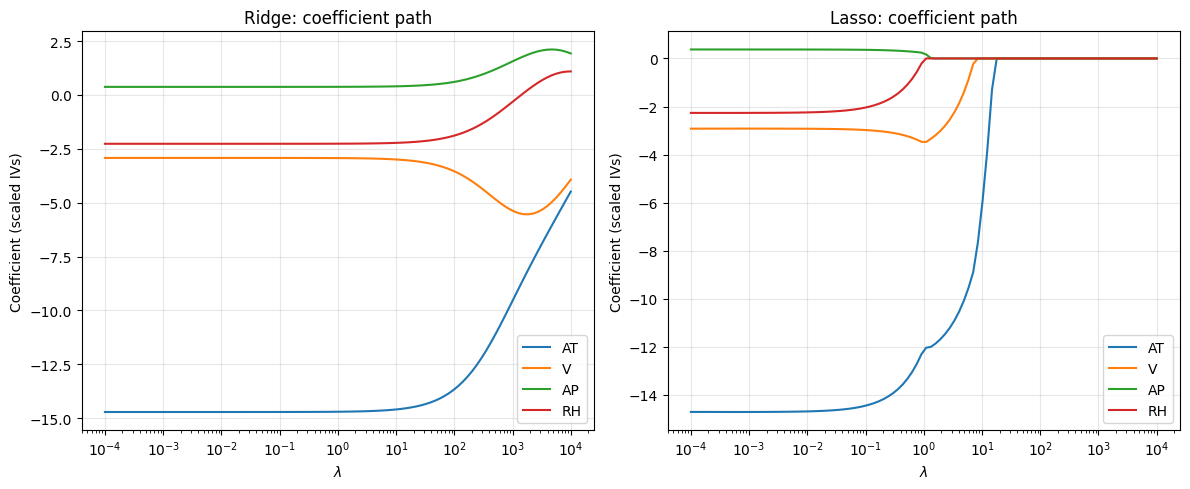

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso

# 5.1–5.2: Load usina.csv, scale IVs, define λ range (100 log-spaced values)
df = pd.read_csv('usina.csv')
feature_names = ['AT', 'V', 'AP', 'RH']
X = df[feature_names]
y = df['PE'].values

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

# λ range: from small (near OLS) to large (strong shrinkage); log-spaced avoids edge cases
lambdas = np.logspace(-4, 4, 100)

# 5.3: For each λ, fit Ridge and Lasso and record coefficients
ridge_coefs = np.zeros((len(lambdas), len(feature_names)))
lasso_coefs = np.zeros((len(lambdas), len(feature_names)))

for i, lam in enumerate(lambdas):
    ridge = Ridge(alpha=lam).fit(X_sc, y)
    lasso = Lasso(alpha=lam).fit(X_sc, y)
    ridge_coefs[i] = ridge.coef_
    lasso_coefs[i] = lasso.coef_

# Tables: coefficient value vs. λ (rounded for display)
ridge_table = pd.DataFrame(
    np.column_stack([lambdas, ridge_coefs]),
    columns=['lambda'] + feature_names
).round(6)
lasso_table = pd.DataFrame(
    np.column_stack([lambdas, lasso_coefs]),
    columns=['lambda'] + feature_names
).round(6)

print('Ridge: coefficient values by λ')
display(ridge_table)
print('Lasso: coefficient values by λ')
display(lasso_table)

# 5.4: Plot coefficient value vs. λ — Ridge
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
for j, name in enumerate(feature_names):
    ax.plot(lambdas, ridge_coefs[:, j], label=name)
ax.set_xscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Coefficient (scaled IVs)')
ax.set_title('Ridge: coefficient path')
ax.legend()
ax.grid(True, alpha=0.3)

# 5.4: Plot coefficient value vs. λ — Lasso
ax = axes[1]
for j, name in enumerate(feature_names):
    ax.plot(lambdas, lasso_coefs[:, j], label=name)
ax.set_xscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Coefficient (scaled IVs)')
ax.set_title('Lasso: coefficient path')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### What happens to coefficients as λ increases in Ridge vs Lasso?
As the regularization parameter λ increases, the magnitudes of the coefficients decrease for both Ridge and Lasso regression. In Ridge regression, coefficients shrink smoothly toward zero but remain nonzero across the entire range of λ. In contrast, Lasso regression drives several coefficients exactly to zero at sufficiently large λ, producing a sparse model.

### Which regression is better under multicollinearity in IVs, and why?
As λ increases, Ridge reduces coefficient magnitudes in a stable way (less variance in estimates), whereas Lasso’s paths show coefficients hitting exactly zero—evidence it is performing selection that can be arbitrary with correlated IVs—so Ridge is the safer choice for multicollinearity.

### Which regression is better for feature selection, and why?
Lasso regression is better for feature selection because its L1 regularization drives some coefficients exactly to zero as λ increases, as seen in the coefficient paths, effectively removing less important features from the model.